In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


## Load the data determine the outlier rows

In [3]:
input_path = '/Users/jonaheaton/Documents/hulahoop_data/all_ellipse_data.csv'

df = pd.read_csv(input_path)

In [5]:
df_vals = (df.drop(['frame','video_id','file_name'], axis=1)).values

In [6]:
df_vals = StandardScaler().fit_transform(df_vals)


In [7]:
outlier_rows = np.any(np.abs(df_vals) > 3, axis=1)
print('total number of rows: ', len(outlier_rows))
print('number of outliers: ', np.sum(outlier_rows))

total number of rows:  40206
number of outliers:  1970


In [8]:
df.loc[outlier_rows,ellipse_cols] = np.nan

In [9]:
output_path = '/Users/jonaheaton/Documents/hulahoop_data/all_ellipse_data_outliers_as_nan.csv'
df.to_csv(output_path, index=False)

## Plot the data to see where the outlier rows show up

In [13]:
n_components = 10
pca  = PCA(n_components=n_components)
principalComponents = pca.fit_transform(df_vals)
print('explained variance ratio: ', pca.explained_variance_ratio_)
pca_cols = ['PCA' + str(i) for i in range(1,n_components+1)]

principalDf = pd.DataFrame(data = principalComponents, columns = pca_cols)
principalDf['frame'] = df['frame']
principalDf['video_id'] = df['video_id']
principalDf['file_name'] = df['file_name']
principalDf['outlier'] = outlier_rows

explained variance ratio:  [0.30499154 0.25798315 0.13602872 0.10109147 0.08243319 0.04133113
 0.02885833 0.02391507 0.02127164 0.00209575]


Text(0, 0.5, 'Explained Variance Ratio')

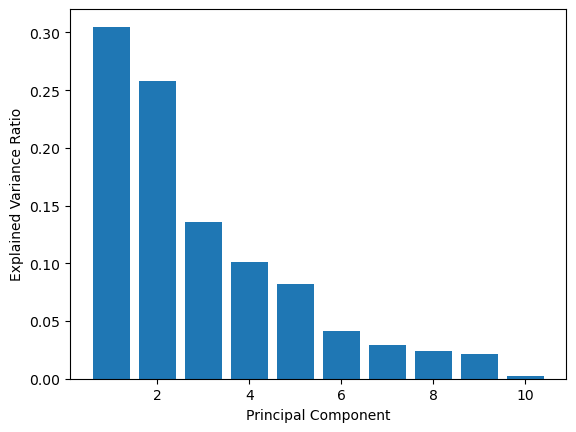

In [14]:
# plot explained variance ratio for each component 
plt.bar(range(1,n_components+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

Text(0, 0.5, 'PCA2: (25.80%)')

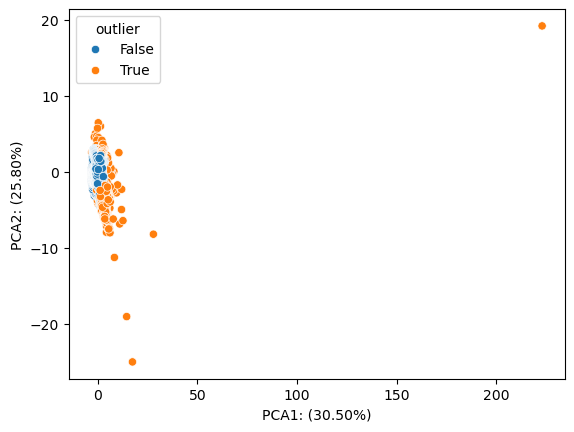

In [15]:

sns.scatterplot(x='PCA1',y='PCA2',data=principalDf, hue='outlier')
# rename the axis labels to include the explained variance ratio
plt.xlabel('PCA1: ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
plt.ylabel('PCA2: ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))

Text(0, 0.5, 'PCA2: (25.80%)')

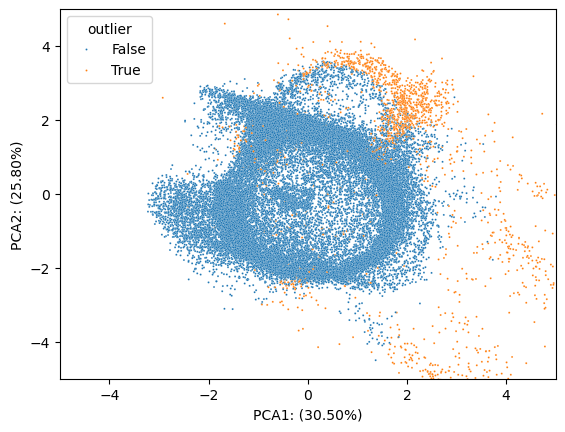

In [23]:
sns.scatterplot(x='PCA1',y='PCA2', data=principalDf, hue='outlier',s=2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('PCA1: ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
plt.ylabel('PCA2: ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))


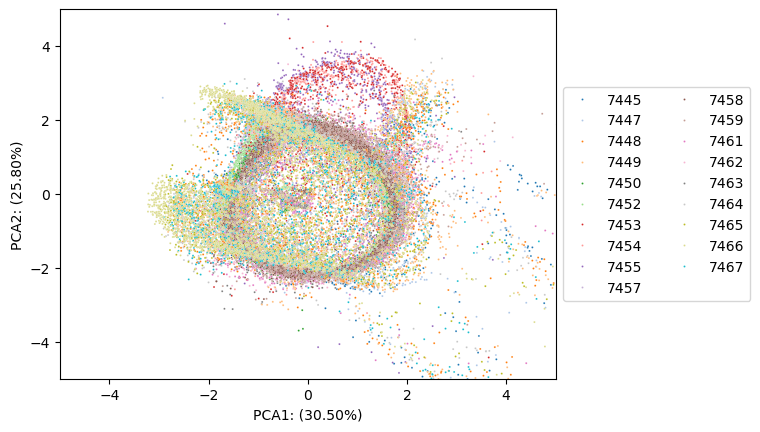

In [21]:
sns.scatterplot(x='PCA1',y='PCA2', data=principalDf, hue='video_id',palette='tab20',s=2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('PCA1: ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
plt.ylabel('PCA2: ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
# place the legend outside of the plot, and make the legend two columns
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

## Determine which rows are used for training, validation and testing

- choose 2 'video_id' to be held-out entirely for testing
- choose 2 'video_id' to be held out entirely for validation
- for the remaining video_id, for each video_i, dchoose the first 80% of the rows for training and the last 20% for validation and testing
- create a new columns 'data_type' to indicate whether the row is for training, validation or testing



In [24]:
df['video_id'].value_counts()

video_id
7463    3960
7452    3669
7457    3663
7458    3642
7450    3624
7466    2685
7449    2484
7465    1875
7448    1872
7464    1530
7455    1491
7467    1374
7445    1275
7454    1236
7447    1215
7461    1188
7462    1167
7453    1143
7459    1113
Name: count, dtype: int64

In [25]:
print('number of video ids: ', len(df['video_id'].unique()))


number of video ids:  19


In [36]:
def assign_data_types(df):
    # Ensure randomness is reproducible
    np.random.seed(42)
    
    video_ids_ordered_by_size = df['video_id'].value_counts().index.tolist()
    large_videos = video_ids_ordered_by_size[:int(len(video_ids_ordered_by_size)/2)]
    small_videos = video_ids_ordered_by_size[int(len(video_ids_ordered_by_size)/2):]

    # Shuffle the video_id to ensure random selection

    np.random.shuffle(large_videos)
    np.random.shuffle(small_videos)

    # Select video IDs for testing and validation
    test_ids = large_videos[:1] + small_videos[:1]
    validation_ids = large_videos[1:2] + small_videos[1:2]
    training_ids = large_videos[2:] + small_videos[2:]
    print('test_ids: ', test_ids)
    print('validation_ids: ', validation_ids)
    print('training_ids: ', training_ids)
    
    # Initialize the new column with empty strings
    df['data_type'] = ''
    
    # Assign 'test' and 'validation' to the selected video IDs
    df.loc[df['video_id'].isin(test_ids), 'data_type'] = 'test'
    df.loc[df['video_id'].isin(validation_ids), 'data_type'] = 'validation'
    
    # Process the remaining videos for training and validation split
    for video_id in training_ids:
        video_df = df[df['video_id'] == video_id]
        val_split_index = int(len(video_df) * 0.8)  # Calculate the 80% index
        test_split_index = int(len(video_df) * 0.9)  # Calculate the 90% index
        # Assign 'training' to the first 70% of rows
        df.loc[video_df.index[:val_split_index], 'data_type'] = 'training'
        # Assign 'validation' to the last 30% of rows
        df.loc[video_df.index[val_split_index:test_split_index], 'data_type'] = 'validation'
        # Assign 'test' to the last 50% of rows
        df.loc[video_df.index[test_split_index:], 'data_type'] = 'test'
    
    return df

In [37]:
df = assign_data_types(df)

test_ids:  [7465, 7464]
validation_ids:  [7452, 7455]
training_ids:  [7466, 7463, 7448, 7457, 7450, 7458, 7449, 7453, 7447, 7445, 7454, 7462, 7459, 7461, 7467]


In [38]:
df['data_type'].value_counts()

data_type
training      25308
validation     8321
test           6577
Name: count, dtype: int64

In [39]:
df.to_csv('/Users/jonaheaton/Documents/hulahoop_data/all_ellipse_data_final.csv', index=False)

## Example Training

In [2]:
df = pd.read_csv('/Users/jonaheaton/Documents/hulahoop_data/all_ellipse_data_final.csv')

In [3]:
from utils import create_sequences

In [4]:
ellipse_cols = [col for col in df.columns if 'ellipse' in col]

In [5]:
df_train = df[df['data_type'] == 'training'].copy()
df_val = df[df['data_type'] == 'validation'].copy()
df_test = df[df['data_type'] == 'test'].copy()

In [6]:

frames_train = df_train['frame'].values
data_train = df_train[ellipse_cols].values

In [7]:
X_train, y_train, t_train = create_sequences(data_train, timesteps=10, frames=frames_train)

In [10]:
data_train.shape

(25308, 10)

In [8]:
X_train.shape

(22458, 10, 10)

In [12]:
from model import HulaHoopLSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [14]:
model = HulaHoopLSTM(input_size=10, hidden_size=64, output_size=10, num_layers=3, data_scaler=MinMaxScaler())


In [15]:
model.fit(X_train, y_train, num_epoch=100, batch_size=64)

Epoch 0:	 loss=0.0313
Epoch 10:	 loss=0.0017
Epoch 20:	 loss=0.0013
Epoch 30:	 loss=0.0011
Epoch 40:	 loss=0.0009
Epoch 50:	 loss=0.0008
Epoch 60:	 loss=0.0007
Epoch 70:	 loss=0.0006
Epoch 80:	 loss=0.0005
Epoch 90:	 loss=0.0005


In [16]:

X_val, y_val, t_val = create_sequences(df_val[ellipse_cols].values, timesteps=10, frames=df_val['frame'].values)

In [17]:
model.evaluate(X_val, y_val, ellipse_cols)

/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


{'top ellipse X': 39.16437911987305,
 'top ellipse X_scaled': 0.00038713181857019663,
 'top ellipse Y': 63.90071487426758,
 'top ellipse Y_scaled': 0.0003133107384201139,
 'top ellipse Major Axis': 132.80120849609375,
 'top ellipse Major Axis_scaled': 0.003013339126482606,
 'top ellipse Minor Axis': 290.1104431152344,
 'top ellipse Minor Axis_scaled': 0.0005725742666982114,
 'top ellipse Angle': 2.3439981937408447,
 'top ellipse Angle_scaled': 0.00038462382508441806,
 'bottom ellipse X': 13.99781322479248,
 'bottom ellipse X_scaled': 0.00045890171895734966,
 'bottom ellipse Y': 13.51362419128418,
 'bottom ellipse Y_scaled': 0.00024397183733526617,
 'bottom ellipse Major Axis': 4.200969696044922,
 'bottom ellipse Major Axis_scaled': 0.0007631630869582295,
 'bottom ellipse Minor Axis': 2.080174684524536,
 'bottom ellipse Minor Axis_scaled': 0.00031811962253414094,
 'bottom ellipse Angle': 158.5253143310547,
 'bottom ellipse Angle_scaled': 0.004899895749986172,
 'total': 0.001135503174737

In [18]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 1.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.5 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for greenlet: filename=greenlet-3.0.3-cp311-cp311-macosx_10_9_x86_64.whl size=214384 sha256=1ff7648acb930d402b8301362d5dc1b9be77452d6927c42c70936b34ceb57e3b
  Stored in directory: /User